# Single node evaluation

In [2]:
import functools
import os
from pathlib import Path

from utils.multiprocessing import run_in_parallel

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from utils.model_creators import create_LSTM

import json
from gossiplearning.config import Config
from utils.single_node_training import train_single_nodes

In [3]:
N_SIMULATIONS = 5
timesteps = 4

dataset = Path("data/datasets/porto_10n_3k")

In [4]:
with open("config.json", "r") as f:
    config = Config.model_validate(json.load(f))

In [21]:
model_creator = functools.partial(
    create_LSTM,
    config=config,
)
model_creator().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4, 9)]            0         
                                                                 
 sequential_3 (Sequential)   (None, 50)                32200     
                                                                 
 fn_0 (Dense)                (None, 1)                 51        
                                                                 
Total params: 32,251
Trainable params: 32,251
Non-trainable params: 0
_________________________________________________________________


In [23]:
run_in_parallel([
    functools.partial(
        train_single_nodes,
        config=config,
        datasets_folder=dataset / str(i) / f"{timesteps}in",
        output_folder= dataset / str(i) / f"{timesteps}in" / "models",
        model_creator=model_creator,
    )
    for i in range(1)
])

Metal device set to: Apple M1 Pro



systemMemory: 32.00 GB
maxCacheSize: 10.67 GB


# Test & prototyping

Test on just one node and network configuration

In [ ]:
# i=0
# train_single_nodes(
#     config=config,
#     datasets_folder=dataset / str(i) / f"{config.training.timesteps}in",
#     output_folder= dataset / str(i) / f"{config.training.timesteps}in" / "models",
#     model_creator=model_creator,
#     verbose=1,
#     # n_functions=3,
# )

In [13]:
from keras.saving.saving_api import load_model
from utils.data import load_npz_data

node = 0
function = 0
dataset_folder = dataset / "0" / f"4in_scaled"
model = load_model(dataset_folder / "models"/ f"{node}_single.h5" )

_, _, _, _, X_test, Y_test = load_npz_data(str(dataset_folder / f"node_{node}.npz"))


predictions = model.predict(X_test, use_multiprocessing=True, batch_size=config.training.batch_size)
# Y_test = Y_test[:, 0, function].flatten()

9/9 [==============================] - 0s 7ms/step


In [14]:
predictions.shape

(2102, 1)

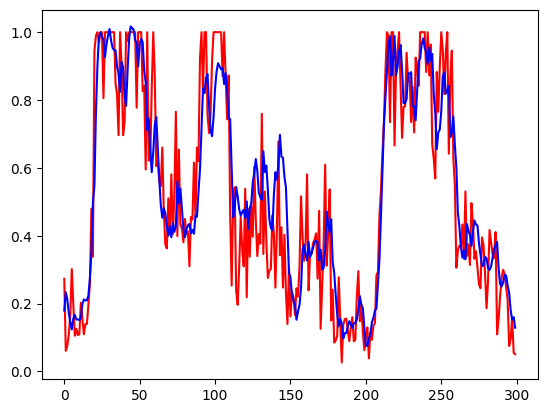

In [15]:
from matplotlib import pyplot as plt

func = 0
start = 0
end = 300

fig1, ax1 = plt.subplots()

ax1.plot(
    Y_test[start:end, func],
    label="truth",
    color="red",
)

ax1.plot(predictions[start:end], label="predictions", color="blue")

plt.show()

In [48]:
optVars = model.optimizer.variables()

In [10]:
model2 = model_creator()

In [12]:
model2.optimizer.build(optVars)

AttributeError: 'Adam' object has no attribute 'build'

In [ ]:
for ov in optVars:
    model2.optimizer.add_slot(
        slot_name=ov.name, shape=ov.shape, var=ov
    )

In [ ]:
model2.optimizer._weights = optVars

In [ ]:
optVars[0]

In [ ]:
model2.fit(X_test, Y_test, epochs=1)

In [8]:
from tensorflow.keras.optimizers import Adam
a = Adam()

In [ ]:
a.build(optVars)

In [9]:
type(a)

keras.optimizers.adam.Adam